<a href="https://colab.research.google.com/github/MaLuWi/guayas_store_project/blob/main/Time_Series_Project_Masterschool_filtering_for_Guayas_region.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('/content/drive/MyDrive/Time Series/train.csv', nrows=2e6)
df_stores = pd.read_csv('/content/drive/MyDrive/Time Series/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/Time Series/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/Time Series/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/Time Series/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/Time Series/holidays_events.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Filtering the Data for the Guayas region and the top three familys**

In [3]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/Time Series/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-3-76d42c2d7c8f>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/Time Series/train.csv', chunksize=chunk_size):


In [5]:
df_train.shape #alot of rows! lets filter it out for most important item category

(22941656, 6)

In [6]:
# Compute the number of items per family and select the top 3 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # Keep only the top 3 families
top_3_families

,Family,Item Count
0,GROCERY I,1334
1,BEVERAGES,613
2,CLEANING,446


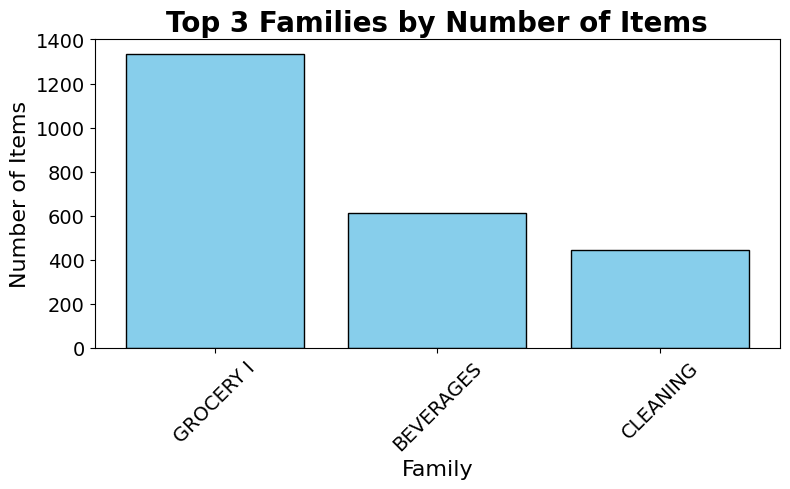

In [7]:
# Plot the top 3 families
plt.figure(figsize=(8, 5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 3 Families by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

In [8]:
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

In [9]:
df_train.shape #From around 22.9 millions of rows to around 14.7

(14745768, 6)

In [10]:
df_train.head(10)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.0,NaN
2,18791,2013-01-02,24,105575,2.0,NaN
3,18792,2013-01-02,24,105577,1.0,NaN
4,18793,2013-01-02,24,105693,7.0,NaN
5,18794,2013-01-02,24,105737,17.0,NaN
6,18795,2013-01-02,24,105857,1.0,NaN
7,18796,2013-01-02,24,106716,3.0,NaN
10,18799,2013-01-02,24,108786,3.0,NaN
11,18800,2013-01-02,24,108797,2.0,NaN
13,18802,2013-01-02,24,108862,3.0,NaN


In [11]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [12]:
#I want to compare the shape of df_items to the df_items contained in the new df_train -
#but filtering seems obsolete given the small file size (in comparison to the train set)
filtered_item_ids = df_train['item_nbr'].unique()
df_items2 = df_items[df_items['item_nbr'].isin(filtered_item_ids)]

In [13]:
df_items.shape

(4100, 4)

In [14]:
df_items2.shape

(2323, 4)

In [15]:
#check how many items from top 3 are missing in the filtered set
filtered_counts = df_items2['family'].value_counts().reset_index()
filtered_counts.columns = ['Family', 'Item Count Filtered']

#Merge top_3_families from earlier with the filtered_counts
comparison = pd.merge(top_3_families, filtered_counts, on='Family', how='left')

# Rename full count column
comparison = comparison.rename(columns={'Item Count': 'Item Count Full'})
comparison #we see small differences in the number of items: not for sale in guayas

,Family,Item Count Full,Item Count Filtered
0,GROCERY I,1334,1277
1,BEVERAGES,613,602
2,CLEANING,446,444


Next steps

->Data Exploration

->Find out if there are any missing values and eliminate them. As for the missing dates, fill them up with zero sales.

->Handle outliers in unit_sales if there are any.

->Engineer features similar to what we did in the in this theory of this sprint
Save the prepared dataset as a .csv file to your google drive. During the next weeks, will get back to this data!

EDA for the region of our interest ("Guayas")
Conduct an exploratory data analysis (EDA). Find out the answers for the questions that are similar to what found answers for the "Pichincha" region but now for the "Guayas" region.
Feel free to examine the data even further! It would enrich your project and lead you to better data understanding.

In [16]:
df_train.to_csv('/content/drive/MyDrive/Time Series/df_train_filtered.csv', index=False)
#i will use this set for feature engineering in another colab. To prevent size explosion I'll do feature engineering separately